In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

### **Init**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [5]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [6]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [7]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        l = len(row.text)
        summs = []
        for t in row.text:
            summ_enc = model.generate(
                tokenizer.encode(t, return_tensors='pt').to(device),
                min_length = int(config.BULLETS_MIN_LEN /l),
                max_length = int(config.BULLETS_MAX_LEN /l),
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summs.append(tokenizer.decode(summ_enc, skip_special_tokens=True))

        summ = ' '.join(summs)
        print_example(idx, ' '.join(row.text), summ, row.bullets)

##### Plot Evaluation

In [33]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, len(config.ROUGE_TYPES)+2))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-1]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-1]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.yticks(np.linspace(0, 100, 21))
    plt.xticks(xticks, config.ROUGE_TYPES+['Cosine Sim'], fontsize='x-large')
    plt.show()

## **Baseline**

In [9]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_chunk_chapter/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/baseline_output/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [10]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])\
    .groupby(level=[0, 1], sort=False).agg({'bullets': lambda b: list(b)[0], 'text': lambda t: list(t)})

### **Print and Summarization**

##### Print Train Examples

In [34]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

(9781908541963, 'chapter12')
Liver transplantation . About 6000 liver transplants are performed annually in both the USA and Europe . After transplant, most patients enjoy long-
term survival and dramatic improvements in quality of life . Many patients with advanced liver disease, however, are not candidates for liver
transplantation, in part due to the limited supply of donor organs . Referring physicians should understand the importance of timing the referral for
liver transplantation, be familiar with its indications and contraindications and be comfortable with a pretransplantation evaluation . Indications
and contraindications . Liver transplantation may be a viable option for patients with advanced liver disease of almost any etiology . In the USA, the
most common indications for transplantation resulting from chronic liver disease are viral hepatitis and alcoholic liver disease (ALD) (Table 12.1) .
Severe liver disease that has resulted from acute disorders may also require live

(9781908541703, 'ch_5')
Symptoms of breast cancer . Although a lump in the breast is the most common presenting symptom of breast cancer, a variety of other symptoms may be
present (Table 4.1) . Lumps resulting from breast cancer are generally single, hard and painless, and may be irregular in shape . Fibroadenomas,
however, may also appear as single hard lumps . Typically, breast cancers are about 2 cm in diameter by the time they become large enough to palpate .
Approximately 60% arise in the upper outer quadrant of the breast, but any area of the breast can be affected . Pain in the breast is seldom due to
cancer . The most common cause is the normal periodic pain during the menstrual cycle (cyclic mastalgia) . In many cases it is due to costochondritis
(Tietze's syndrome) and it is possible that referred pain from this may explain many cases of non-cyclic mastalgia; the pathophysiology of Tietze's
syndrome is poorly understood . However, pain does not exclude a cancer . Bleeding fr

(9781908541406, 'ch_3')
Normal hemostasis . In health, hemostasis ensures that blood remains fluid and contained within the vasculature . If a vessel wall is damaged, a
number of mechanisms are promptly activated to limit bleeding by a complex series of interrelated reactions involving endothelial cells, plasma
coagulation factors, platelets and fibrinolytic proteins . The activities of these components are finely balanced between keeping the blood fluid and
preventing excessive activation of the procoagulants, which would lead to intravascular thrombosis . It is helpful to consider the hemostatic process
as three distinct phases . Primary hemostasis occurs after damage to the vessel wall, and involves vasoconstriction and adhesion of platelets in a
monolayer on exposed subendothelial fibrils . Subsequently, further platelets aggregate to form a platelet plug, which stems the flow of blood .
Secondary hemostasis involves activation of the coagulation system, leading to the generation o

(9781910797723, 'chp2')
How cancers evade the immune system . The possibility of harnessing the immune system to attack cancer cells was first proposed over 100 years ago,
but effective immunotherapies have until recently proved elusive because of the ability of cancer cells to evade the immune system . Indeed, as noted
in the previous chapter, this ability can be considered one of the defining features of cancer . The cancer immunity cycle . The response of the
immune system to cancer cells is a cyclical process (Figure 2.1) that may in principle be self-perpetuating, leading to a heightened immune response .
Initially, cancer cells are detected by natural killer (NK) cells, which interact with specific ligands on the cancer cell surface, leading to the
destruction of the cancer cells . This causes the release of cancer antigens that bind to dendritic cells or other antigen-presenting cells (APCs),
leading to cytokine secretion by APCs and priming the activation of T cells in lymphoid

(9781912776238, 'ch9')
Formulary considerations: supportive care biosimilars . Many of the currently approved biosimilars are of interest to hematologists, oncologists and
pharmacists specializing in those disciplines and are likely to feature strongly in formulary committee discussions . This and the following chapter
summarize the important special issues that arose in approving these biosimilars, as discussed in European Public Assessment Reports (EPARs) and the
US Food and Drug Administration (FDA) Oncology Drug Advisory Committee (ODAC) briefings and discussions . Three are supportive care growth factors -
epoetin alfa, filgrastim and pegfilgrastim - which are almost identical to natural products the body makes . They are often used as replacement
therapy or to augment the body's own response and are characterized by simple modes of action through one receptor-mediated pathway . The second group
of three are direct anti-cancer therapies: rituximab, trastuzumab and bevacizumab . Th

(9781910797631, 'chp1')
Etymology and history . The word depression derives (via French) from the Late Latin deprimere, which means to press or push down; it has many
different meanings that are connected by this sense of a lower or downward inclination . Its use in the fields of geology, economics, medicine,
meteorology and psychology share this meaning of a reduced function, downturn and sunken or lower level . A distinct condition characterized by a
dejected mood has been evident in writings since antiquity, with key features alluded to in the Christian Bible (exempli gratia Psalms 32, 38, 143;
1Kings 19, 1-5; Job 17), and a long tradition systematized in the medical writings of Hippocrates and Galen, who theorized about bodily fluids called
humors, the imbalance of which was seen as being responsible for disease (Figure 1.1) . A tendency toward melancholy was understood to be related to
an excess of the humor associated with coldness and dryness - black bile; indeed, the term melan

(9781908541178, 'ch_5')
It is relatively easy to think of radiological or laboratory tests that could be performed after an initial history and physical examination has been
completed . However, it is important to decide which, if any, of these tests will increase understanding of the patient's problem or result in a
specific modification of therapy . As the specific pain generator of many low back pain disorders cannot be precisely characterized, the diagnostic
limitations of modern, expensive technology must be acknowledged . However, the realities of modern clinical practice puts the physician under
pressure from the patient or family to perform 'all the necessary tests', or from a medical insurer not to perform them . The practitioner may also
feel compelled to do 'marginal' tests under medicolegal pressure . All these factors need to be considered as you evaluate patients with low back
pain, beyond the information gathered during the office examination . The main options for furth

(9781910797662, 'ch02')
Pathology and biology . The histological types of primary carcinoma that occur in the bladder are shown in Table 2.1 . Urothelial cancer (UC; Figure
2.1) is derived from the transitional epithelium . It accounts for almost 90% of the bladder cancers that occur in industrialized countries such as
the USA and the UK, and most discussion of bladder cancer relates to this type . Such tumors may be papillary (confined to the urothelium or lamina
propria) (70-75%) or solid and invasive (20-25%) . Carcinoma in situ (CIS) is an additional and important type seen in about 10% of cases (sometimes
as secondary CIS associated with papillary UC) . CIS is a flat, intraepithelial, high-grade carcinoma, often with increased numbers of mitotic
structures . In approximately half of all cases, CIS occurs as one or more de novo lesions (primary CIS), while in the remainder it occurs in
association with either papillary or solid tumors (secondary CIS) . Coexistent CIS and papillary 

(9781910797310, 'chp6')
First and second-line chemotherapy in advanced NSCLC . Maria-Virginia Bluthgen MD, Department of Cancer Medicine, Gustave Roussy, Villejuif, France .
Chemotherapy is still the mainstay of systemic treatment for patients with metastatic non-small-cell lung cancer (NSCLC) . The main factors
influencing chemotherapy regimen selection are histology of the tumor, comorbidities and performance status (PS) . Since 2004, patients with tumors
harboring sensitizing mutations in the epidermal growth factor receptor (EGFR) gene, may receive an EGFR tyrosine kinase inhibitor (TKI) as an
alternative to chemotherapy (see Chapter 8) . This chapter describes treatment for patients without such actionable mutations . First-line
chemotherapy . A systematic review showed that platinum-based therapy was associated with greater 1-year survival (RR 1.08, 95% CI 1.01-1.16) and
increased response rate (RR 1.11, 95% CI 1.02-1.21) than non-platinum-based therapy . The use of a platinum-ba

(9783318066241, 'ch8')
8 Management of other local complications . Abdominal compartment syndrome . Intra-abdominal pressure (IAP) is the steady-state pressure maintained
within the abdominal cavity . IAP is measured in patients in an intensive care unit setting via an indwelling urinary catheter (transbladder
technique) and is usually 5-7 mmHg in critically ill adults . Moderate-to-severe acute pancreatitis (AP) is associated with increased vascular
permeability (resulting in interstitial edema), retroperitoneal inflammation and collections and with paralytic ileus; it may also be associated with
ascites . These factors increase IAP and may result in intra-abdominal hypertension (a sustained IAP >= 12 mmHg) . Patients with intra-abdominal
hypertension are at risk of developing organ failure (OF), as increased pressure in the abdomen may collapse blood vessels, resulting in
gastrointestinal tract and kidney ischemia and decreased cardiac output . OF can also arise from organ compressio

##### Print Val Examples

In [24]:
print_examples('facebook/bart-base', df_val)

[+] model already present in cache

(9781910797723, 'chp3')
It is also important in regulating T helper cell function . In cancer, IL-6 is also important in . differentiation of myeloid-derived suppressor cells
(MDSCs) . regulation of self-renewal of cancer stem cells . inhibition of apoptosis, thereby promoting tumor growth and progression . enhancing
angiogenesis . the development of cancer cachexia syndrome . IL-6 signaling occurs through binding to the IL-6 receptor in conjunction with gp130
protein and activation of the JAK/STAT signaling pathway (janus kinase/signal transducer and activator of transcription) . Antibodies to IL-6 have
been successfully used in inflammatory conditions such as rheumatoid arthritis (RA), and tocilizumab is registered with the FDA for the treatment of
adult and juvenile forms of RA . Therapeutic antibodies to IL-6 have also been trialed in cancer patients, including studies in the management of
cancer cachexia syndrome . Other cancer therapies target 

##### Summarize Test and Print Examples

In [28]:
def summarize(model_name_or_path, df):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    summaries = []

    pbar = tqdm(total=len(df), 
                position=0,
                leave=True,
                file=sys.stdout)
    for ts in df.text.tolist():
        l = len(ts)
        summs = []
        for t in ts:
            summ_enc = model.generate(
                tokenizer.encode(t, return_tensors='pt').to(device),
                min_length = int(config.BULLETS_MIN_LEN/l),
                max_length = int(config.BULLETS_MAX_LEN/l),
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summs.append(tokenizer.decode(summ_enc, skip_special_tokens=True))
        summ = ' '.join(summs)
        summaries.append(summ)
        pbar.update(1)
    pbar.close()

    df['summary'] = summaries
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [29]:
summarize(
    'sshleifer/distilbart-cnn-12-6', df_test)

100%|██████████| 43/43 [24:06<00:00, 33.63s/it]


,,bullets,text,summary
book,chapter,,,
9781908541277,ch_12,Depression and anxiety are common in patients ...,[Quality of life . Psychiatric comorbidities ....,Depression is the most prevalent psychiatric ...
9781910797907,chp6,The burden of transfusions in pyruvate kinase ...,"[Supportive treatment . At present, the main f...",The main focus of care for pyruvate kinase (P...
9781908541277,ch_8,Sixteen new antiepileptic drugs (AEDs) have be...,[Antiepileptic drugs . Established antiepilept...,Carbamazepine (CBZ) was synthesized by Schind...
9781910797006,ch08,Acute exacerbations of COPD are common and pla...,[Acute exacerbations . Acute exacerbations of ...,In an average UK Health Authority with a popu...
9781910797105,ch06,People with schizophrenia exhibit gray matter ...,[Neuroanatomy and structural imaging . Our kno...,Our knowledge of the neuroanatomy of schizoph...
9783318068207,hh-5,Comprehensive genomic profiles offer a complet...,[The recent improvements in terms of available...,The adoption of broad NGS gene panels may sup...
9781910797105,ch04,Having a close relative with schizophrenia inc...,[The biggest single clue we have about the cau...,The biggest single clue we have about the cau...
9781910797006,ch03,"COPD occurs, though less commonly, in those wh...",[Clinical features . The characteristic sympto...,The characteristic symptom of COPD is breathl...
9781908541406,ch_6,Thrombocytopenia may occur with some inherited...,[Platelet disorders . Platelet function defect...,Some congenital platelet disorders are also a...


### **Evaluation**

In [30]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

  0%|          | 0/43 [34:58<?, ?it/s]


##### Evaluate summaries

In [31]:
def evaluate_model(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [32]:
evaluate_model('sshleifer/distilbart-cnn-12-6')

,,bullets,text,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,cosine_sim
book,chapter,,,,,,,,,,,,,
9781908541277,ch_12,Depression and anxiety are common in patients ...,"[""Quality of life . Psychiatric comorbidities ...",Depression is the most prevalent psychiatric ...,37.500000,34.228188,35.789474,8.148148,7.432432,7.773852,19.117647,17.449664,18.245614,73.309845
9781910797907,chp6,The burden of transfusions in pyruvate kinase ...,"[""Supportive treatment . At present, the main ...",The main focus of care for pyruvate kinase (P...,53.333333,48.854962,50.996016,24.369748,22.307692,23.293173,30.000000,27.480916,28.685259,82.925552
9781908541277,ch_8,Sixteen new antiepileptic drugs (AEDs) have be...,['Antiepileptic drugs . Established antiepilep...,Carbamazepine (CBZ) was synthesized by Schind...,9.302326,30.769231,14.285714,1.754386,5.882353,2.702703,6.395349,21.153846,9.821429,46.379349
9781910797006,ch08,Acute exacerbations of COPD are common and pla...,['Acute exacerbations . Acute exacerbations of...,In an average UK Health Authority with a popu...,15.415020,43.820225,22.807018,5.158730,14.772727,7.647059,9.090909,25.842697,13.450292,65.284139
9781910797105,ch06,People with schizophrenia exhibit gray matter ...,['Neuroanatomy and structural imaging . Our kn...,Our knowledge of the neuroanatomy of schizoph...,34.693878,49.514563,40.800000,14.383562,20.588235,16.935484,19.047619,27.184466,22.400000,75.334245
9783318068207,hh-5,Comprehensive genomic profiles offer a complet...,"[""The recent improvements in terms of availabl...",The adoption of broad NGS gene panels may sup...,34.972678,52.459016,41.967213,13.186813,19.834711,15.841584,18.579235,27.868852,22.295082,75.836414
9781910797105,ch04,Having a close relative with schizophrenia inc...,"[""The biggest single clue we have about the ca...",The biggest single clue we have about the cau...,19.819820,30.985915,24.175824,3.636364,5.714286,4.444444,10.810811,16.901408,13.186813,63.661140
9781910797006,ch03,"COPD occurs, though less commonly, in those wh...","[""Clinical features . The characteristic sympt...",The characteristic symptom of COPD is breathl...,31.474104,45.664740,37.264151,6.800000,9.883721,8.056872,13.545817,19.653179,16.037736,72.276080
9781908541406,ch_6,Thrombocytopenia may occur with some inherited...,"[""Platelet disorders . Platelet function defec...",Some congenital platelet disorders are also a...,29.223744,57.142857,38.670695,6.422018,12.612613,8.510638,12.785388,25.000000,16.918429,83.619714


##### Plot Evaluation

  0%|          | 0/43 [34:28<?, ?it/s]


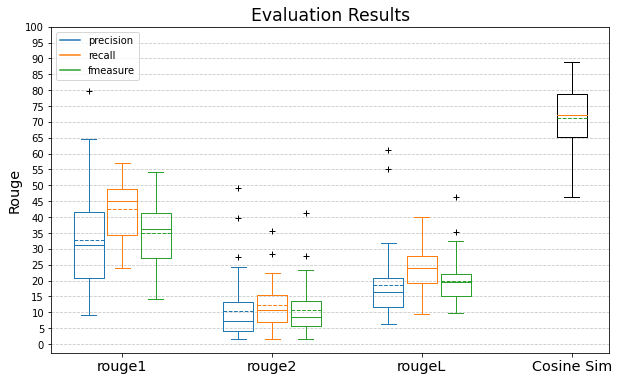

In [35]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')